# Algorithms Comparison & Evaluation
## Table of Contents 
1. Chapter Outline
2. Introduction
3. Read in the data
4. Calculate Performance
5. Evaluate Performance
6. Conculsion

In [13]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os
from copy import copy
import json


data_dir = "../data"
script_dir =  "../scripts"
sys.path.append(script_dir)

# import python scientific stack
import pandas as pd

pd.options.display.float_format = "{:,.4f}".format
import pandas_datareader as pdr
import numpy as np

# import monthly_returns_heatmap as mrh
import math

import ffn
import pyfolio as pf
import quantstats as qs

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline
savefig_kwds = dict(dpi=300, bbox_inches="tight")

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from utils import *

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-07-26T10:59:42.712588+02:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas           : 1.5.3
pandas_datareader: 0.10.0
numpy            : 1.23.5
sklearn          : 1.2.2
statsmodels      : 0.14.0
scipy            : 1.10.1
matplotlib       : 3.7.1
seaborn          : 0.12.2



<IPython.core.display.Javascript object>

In [14]:
%load_ext nb_black

sns_params = {
    "xtick.major.size": 1,
    "ytick.major.size": 1,
    "font.size": 10,
    "font.weight": "medium",
    "figure.figsize": (12, 10),
    "font.family": "DeJavu Serif",
}

sns.set_style("white", sns_params)
sns.set_context(sns_params)
savefig_kwds = dict(dpi=150, bbox_inches="tight", frameon=True, format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))


def save_image(fig, fn):
    fig.savefig(Path("../visuals" / f"{fn}.png").as_posix(), **savefig_kwds)
    print(f"image saved: {fn}")
    return

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Chapter Outline

1. Introduction
2. Import algorithm backtest data
3. Evaluate algorithm results
4. Conclusions
5. Resource and Citations

## Introduction

Test of an gmm inverse VAR portfolio allocation algorithm verse some common benchmarks. 

The symbol universe consisted of the following ETFs:

_"SPY", "QQQ", "DIA", "TLT", "GLD", "EFA", "EEM", 'BND', 'VNQ'_

- All the algorithms start from `2008-05-01` and run until `2023-07-25`.
- Rebalance daily.
- Target weights had a 5% corridor or +/- 2.5% (to minimize transaction costs). 

The benchmark algorithms are the equal weight and 60/40 SPY/BND algorithm. 

I tested 2 Historical VAR models. 
One with a lookback of 252 days and the other with a lookback 60 days. 

I tested 2 GMM VAR models.
One with a lookback of 252 days and the other 60 days. 
I restricted the model to 2 components.

## Read in the data

In [15]:
def read_bt_json(fp):
    """fn: read Quantconnect backtest json"""
    with open(fp, encoding="utf-8") as f_in:
        return json.load(f_in)


def extract_portfolio_equity(jdata):
    """fn: extract port equity timeseries from Quantconnect json"""
    d = jdata["Charts"]["Strategy Equity"]["Series"]["Equity"]["Values"]
    equity = (
        pd.DataFrame(d)
        .rename(columns=dict(x="time", y="equity"))
        .assign(time=lambda df: pd.to_datetime(df.time, utc=True, unit="s"))
        .set_index("time")
    )
    return equity


def _get_column_name(text):
    """fn: to get column name as first text group"""
    # n = 4 # hardcoded based on fn structure
    groups = text.split(".")
    return "_".join(groups[:-1])


def read_port_equity(dir_, fn):
    fp = Path(dir_ / fn)  # .as_posix()
    jdata = read_bt_json(fp)

    # get column name
    col = _get_column_name(fn)
    # extract equity data
    equity = extract_portfolio_equity(jdata).rename(columns=dict(equity=col))
    return equity

<IPython.core.display.Javascript object>

In [16]:
filenames = [
    "equal_weight_benchmark_[2023-07]",
    "60_40_benchmark_[2023-07]",
    "gmm_60_[2023-07]",
    "gmm_252_[2023-07]",
    "historical_60_[2023-07]",
    "historical_252_[2023-07]",
]

dfs = [read_port_equity(Path("../backtests"), f"{fn}.json") for fn in filenames]
df = pd.concat(dfs, axis=1).sort_index().dropna().drop_duplicates()
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           equal_weight_benchmark_[2023-07]  \
time                                                          
2023-07-21 04:00:00+00:00                    2,883,585.1854   
2023-07-22 04:00:00+00:00                    2,883,610.3752   
2023-07-24 13:31:00+00:00                    2,887,797.2302   
2023-07-25 04:00:00+00:00                    2,890,417.4152   
2023-07-25 20:00:00+00:00                    2,890,416.1452   

                           60_40_benchmark_[2023-07]  gmm_60_[2023-07]  \
time                                                                     
2023-07-21 04:00:00+00:00             3,009,348.4638    3,550,955.2881   
2023-07-22 04:00:00+00:00             3,010,168.2638    3,550,889.5734   
2023-07-24 13:31:00+00:00             3,018,026.2038    3,559,033.4134   
2023-0

<IPython.core.display.Javascript object>

## Calculate Performance

In [17]:
def to_price_index(df, start=1):
    return start * (np.exp(df.cumsum()))


def common_sense_ratio(returns):
    # common sense ratio
    ratio = (abs(returns.quantile(0.95)) * returns[returns > 0].sum()) / abs(
        abs(returns.quantile(0.05)) * returns[returns < 0].sum()
    )
    ratio = round(ratio, 2)
    return ratio


def plot_pf(returns):
    plots = [
        pf.plot_rolling_returns,
        pf.plot_annual_returns,
        pf.plot_monthly_returns_heatmap,
        pf.plot_monthly_returns_dist,
        pf.plot_drawdown_underwater,
    ]

    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1.0, 1, 1])

    for i, func in enumerate(plots):

        if i == 0:
            ax = plt.subplot(gs[0, :])
            func(returns, ax=ax)
        elif i < 4:
            ax = plt.subplot(gs[1, i - 1])
            func(returns, ax=ax)
        elif i == 4:
            ax = plt.subplot(gs[2, :])
            func(returns, ax=ax)
        else:
            continue

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [18]:
# keep_stats = test.index[0:7].tolist() + test.index[16:].tolist()
keep_stats = [
    "start",
    "end",
    "rf",
    "total_return",
    "cagr",
    "max_drawdown",
    "calmar",
    "daily_sharpe",
    "daily_sortino",
    "daily_mean",
    "daily_vol",
    "daily_skew",
    "daily_kurt",
    "best_day",
    "worst_day",
    "monthly_sharpe",
    "monthly_sortino",
    "monthly_mean",
    "monthly_vol",
    "monthly_skew",
    "monthly_kurt",
    "best_month",
    "worst_month",
    "yearly_sharpe",
    "yearly_sortino",
    "yearly_mean",
    "yearly_vol",
    "yearly_skew",
    "yearly_kurt",
    "best_year",
    "worst_year",
    "avg_drawdown",
    "avg_drawdown_days",
    "avg_up_month",
    "avg_down_month",
    "win_year_perc",
    "twelve_month_win_perc",
]


def view_strats(strats):
    return ffn.calc_stats(strats).stats.loc[keep_stats]


strats = pd.DataFrame()

# plot helper for labeling scatter plot
def label_point(x, y, val, ax, rotation=10, ha="center", va="baseline"):
    """
    label points on a scatter plot

    See:
        https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
    :param x: pd.Series
    :param y: pd.Series
    :param val: pd.Series
    :param ax: matplotlib axis
    :return:
    """
    a = pd.concat({"x": x, "y": y, "val": val}, axis=1).dropna()
    for i, point in a.iterrows():
        ax.text(
            point["x"],
            point["y"],
            str(point["val"]),
            rotation=rotation,
            horizontalalignment=ha,
            verticalalignment=va,
        )

<IPython.core.display.Javascript object>

In [19]:
"""def calc_stats(returns, bm):
    stats = [f for f in dir(qs.stats) if f[0] != "_"]

    agg_stats = {}
    for stat_func in stats:
        try:
            agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns)
        except:
            try:
                agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns, bm)
            except Exception as e:
                print(e)
                continue

    return pd.DataFrame.from_dict(agg_stats, orient="index")"""

'def calc_stats(returns, bm):\n    stats = [f for f in dir(qs.stats) if f[0] != "_"]\n\n    agg_stats = {}\n    for stat_func in stats:\n        try:\n            agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns)\n        except:\n            try:\n                agg_stats[stat_func] = pd.eval(f"qs.stats.{stat_func}")(returns, bm)\n            except Exception as e:\n                print(e)\n                continue\n\n    return pd.DataFrame.from_dict(agg_stats, orient="index")'

<IPython.core.display.Javascript object>

In [20]:
# strategy returns

for col in df.columns:
    strats[col] = np.log(df[col] / df[col].shift(1))
cprint(strats)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                           equal_weight_benchmark_[2023-07]  \
time                                                          
2023-07-21 04:00:00+00:00                           -0.0069   
2023-07-22 04:00:00+00:00                            0.0000   
2023-07-24 13:31:00+00:00                            0.0015   
2023-07-25 04:00:00+00:00                            0.0009   
2023-07-25 20:00:00+00:00                           -0.0000   

                           60_40_benchmark_[2023-07]  gmm_60_[2023-07]  \
time                                                                     
2023-07-21 04:00:00+00:00                    -0.0059           -0.0095   
2023-07-22 04:00:00+00:00                     0.0003           -0.0000   
2023-07-24 13:31:00+00:00                     0.0026            0.0023   
2023-0

<IPython.core.display.Javascript object>

In [21]:
strats

,equal_weight_benchmark_[2023-07],60_40_benchmark_[2023-07],gmm_60_[2023-07],gmm_252_[2023-07],historical_60_[2023-07],historical_252_[2023-07]
time,,,,,,
2008-06-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-03 04:00:00+00:00,-0.0033,-0.0042,-0.0063,-0.0042,-0.0038,-0.0027
2008-06-04 04:00:00+00:00,-0.0041,-0.0025,-0.0026,-0.0022,-0.0016,-0.0014
2008-06-05 04:00:00+00:00,-0.0010,-0.0013,-0.0022,-0.0032,-0.0021,-0.0022
2008-06-06 04:00:00+00:00,0.0122,0.0100,0.0128,0.0097,0.0080,0.0061
...,...,...,...,...,...,...
2023-07-21 04:00:00+00:00,-0.0069,-0.0059,-0.0095,-0.0093,-0.0063,-0.0064
2023-07-22 04:00:00+00:00,0.0000,0.0003,-0.0000,-0.0000,0.0000,-0.0000
2023-07-24 13:31:00+00:00,0.0015,0.0026,0.0023,0.0020,0.0016,0.0013


<IPython.core.display.Javascript object>

In [22]:
# create strategy result df which holds all the computed metrics
strat_res = pd.concat(
    [view_strats(df[col].dropna()).rename(col) for col in strats.columns], axis=1
)

# add common sense ratios
common_sense_ratios = pd.Series(
    [common_sense_ratio(strats[col].dropna()) for col in strats.columns],
    index=strats.columns,
)

strat_res.loc["common_sense_ratio"] = common_sense_ratios

# add avg of worst 5 drawdown durations in days
avg_worst_5_drawdowns_duration = pd.Series(
    [
        pf.timeseries.gen_drawdown_table(strats[col].dropna()).Duration.iloc[:5].mean()
        for col in strats.columns
    ],
    index=strats.columns,
)
strat_res.loc["avg_worst_5_drawdown_duration"] = avg_worst_5_drawdowns_duration

# add avg of worst 5 drawdowns (%)
avg_worst_5_drawdowns = pd.Series(
    [
        pf.timeseries.gen_drawdown_table(strats[col].dropna())["Net drawdown in %"]
        .iloc[:5]
        .mean()
        * -0.01
        for col in strats.columns
    ],
    index=strats.columns,
)

strat_res.loc["avg_worst_5_drawdowns"] = avg_worst_5_drawdowns

<IPython.core.display.Javascript object>

In [23]:
strats.columns

Index(['equal_weight_benchmark_[2023-07]', '60_40_benchmark_[2023-07]',
       'gmm_60_[2023-07]', 'gmm_252_[2023-07]', 'historical_60_[2023-07]',
       'historical_252_[2023-07]'],
      dtype='object')

<IPython.core.display.Javascript object>

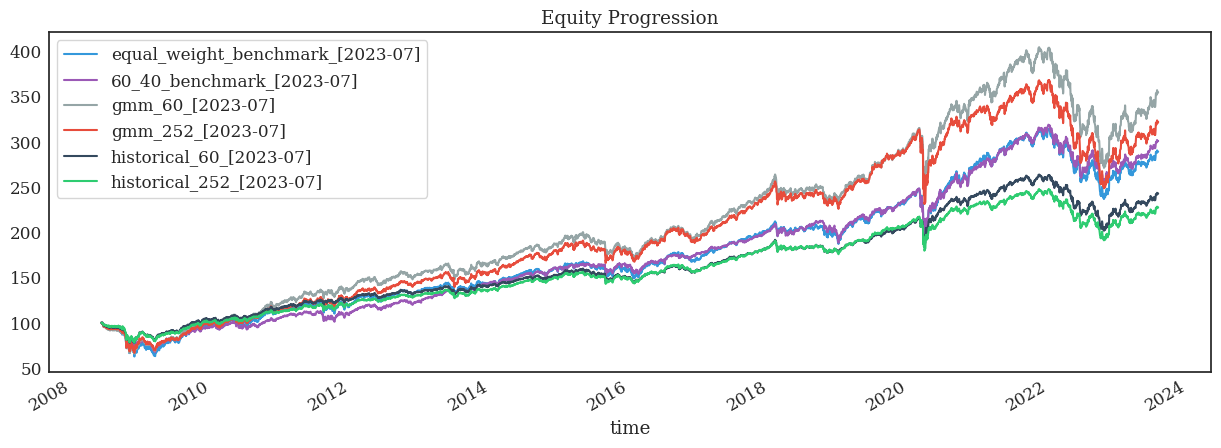

<IPython.core.display.Javascript object>

In [24]:
perf = ffn.calc_stats(df)
perf.plot()
plt.savefig("../visuals/equity_progression")

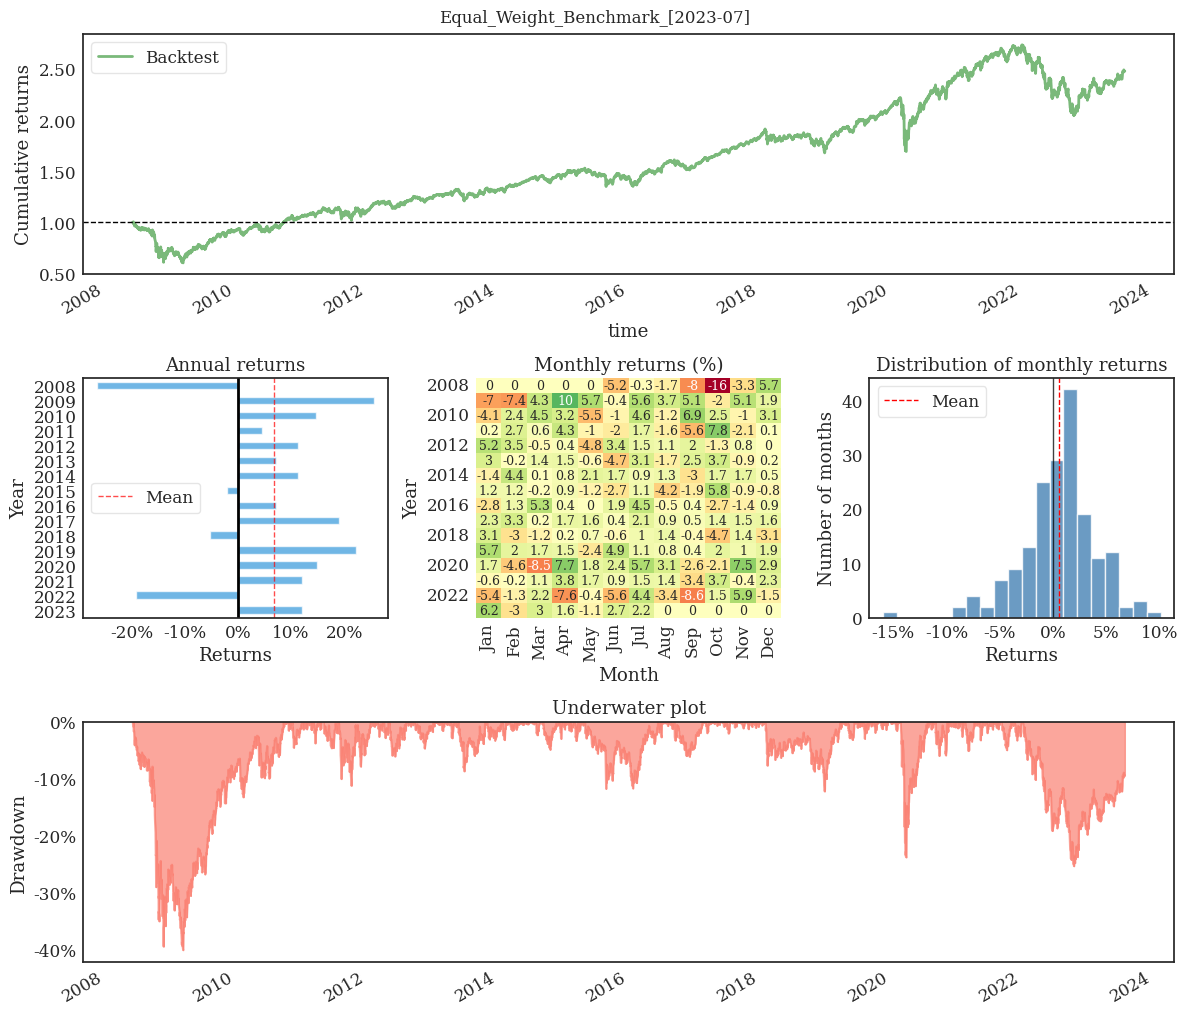

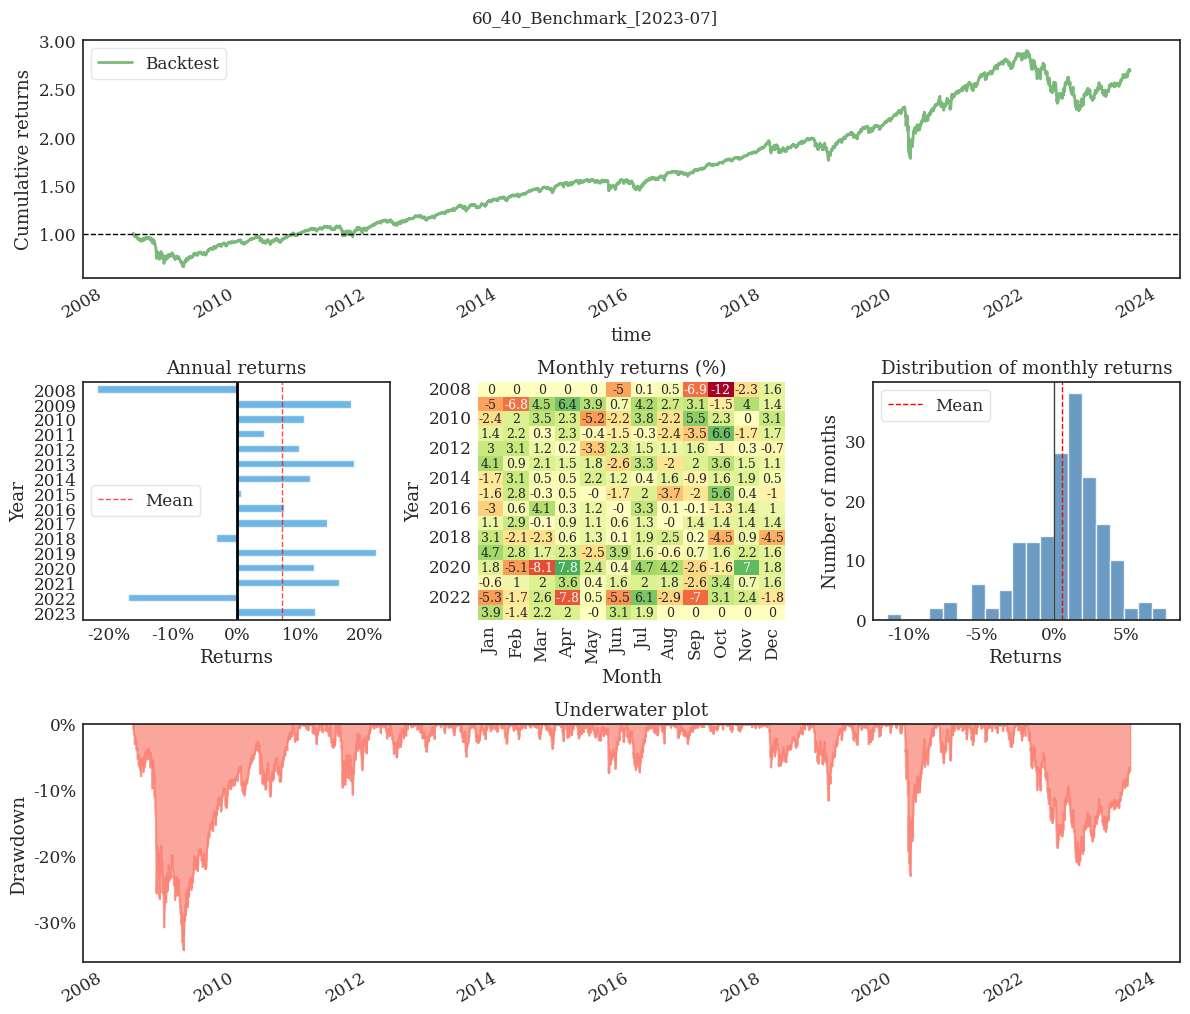

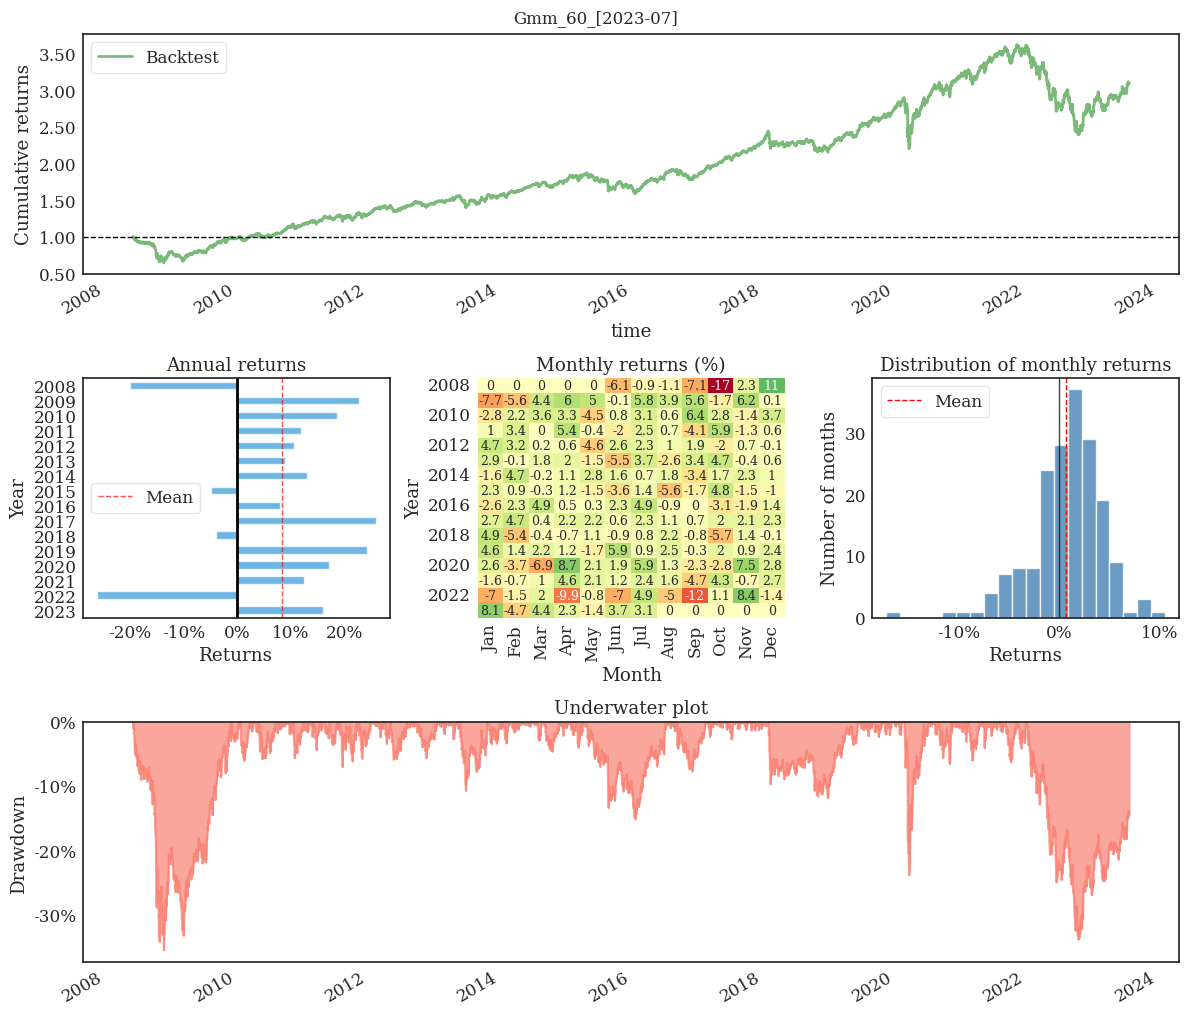

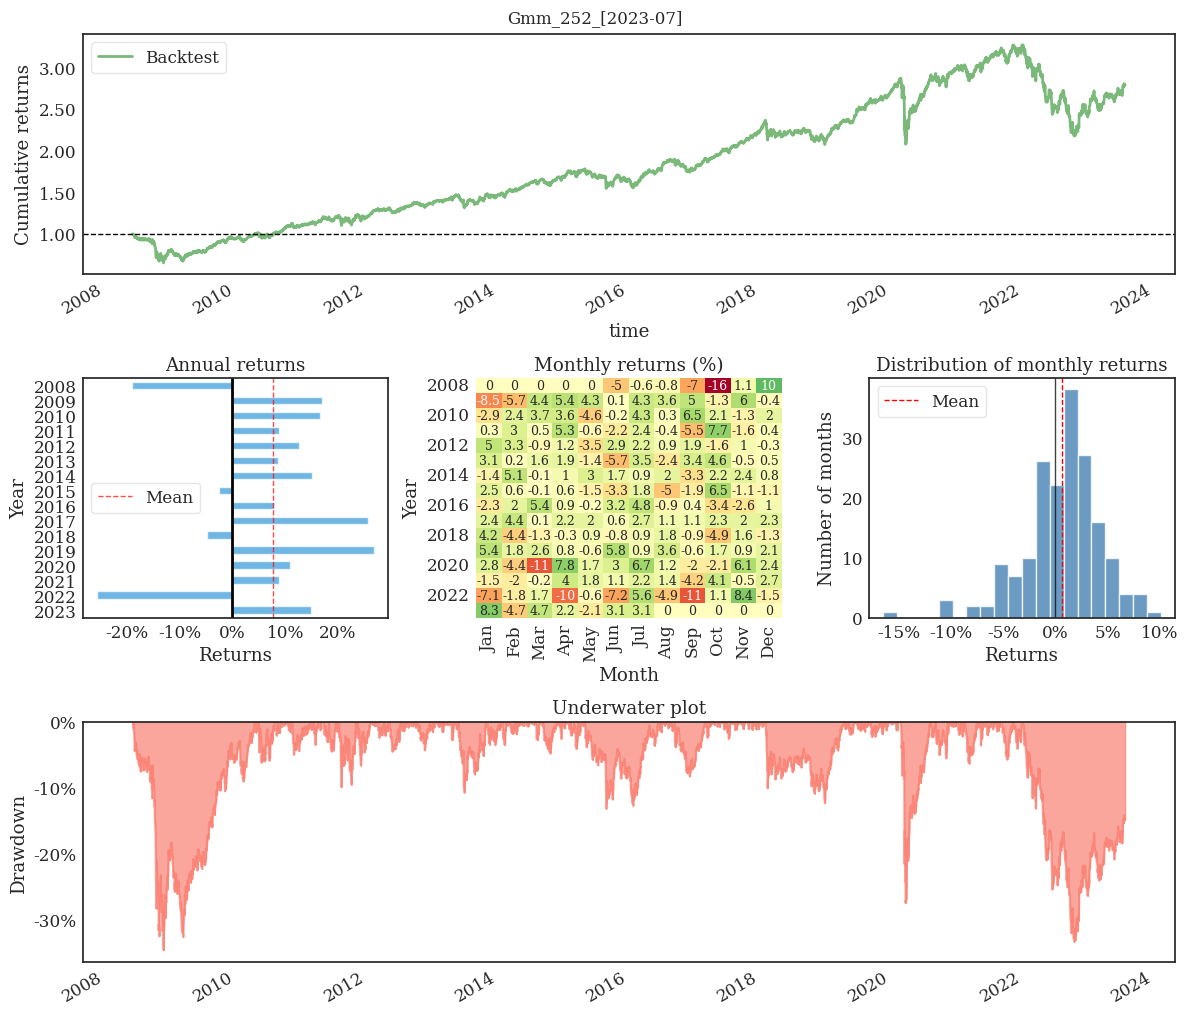

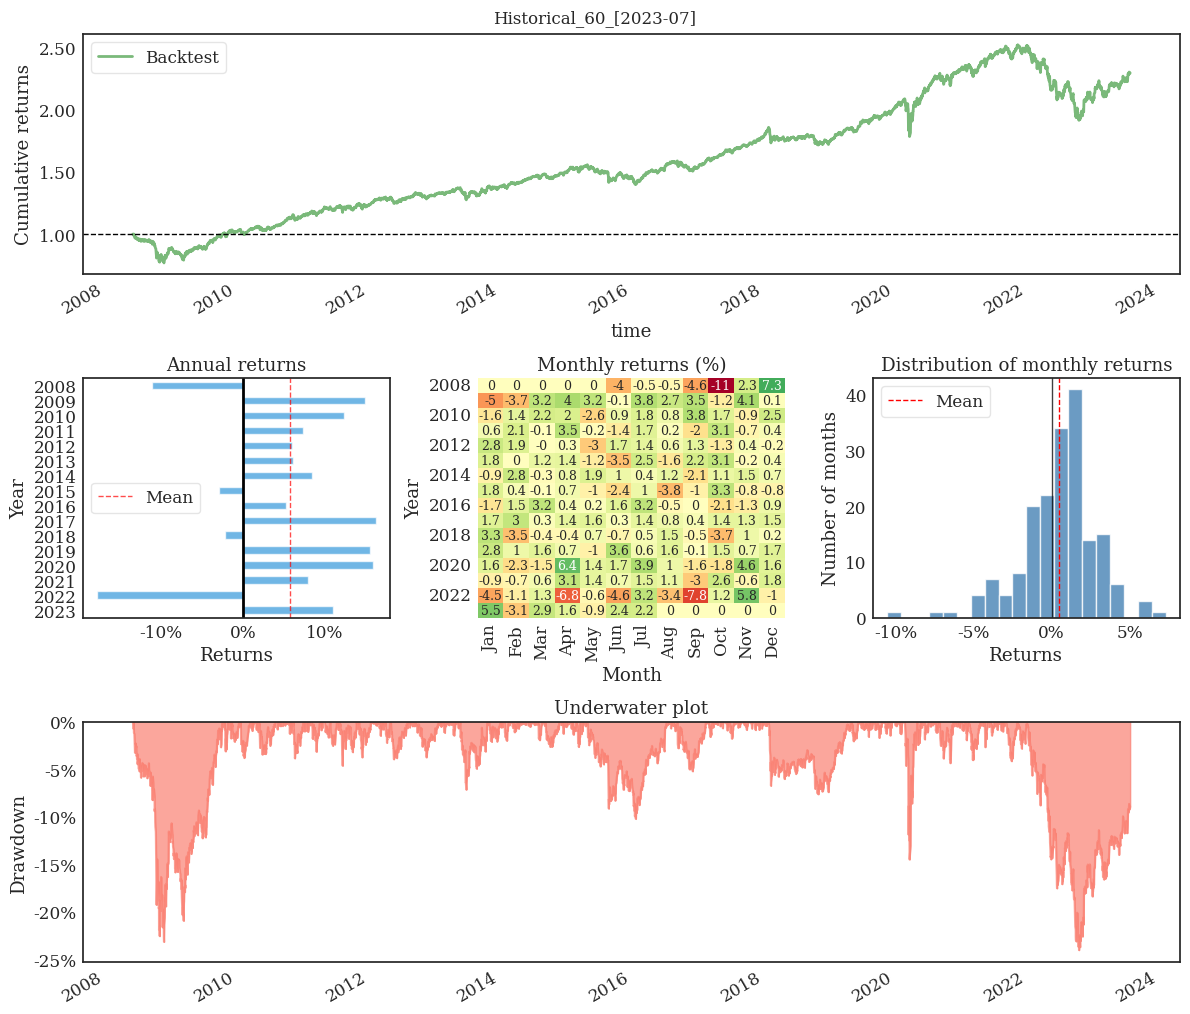

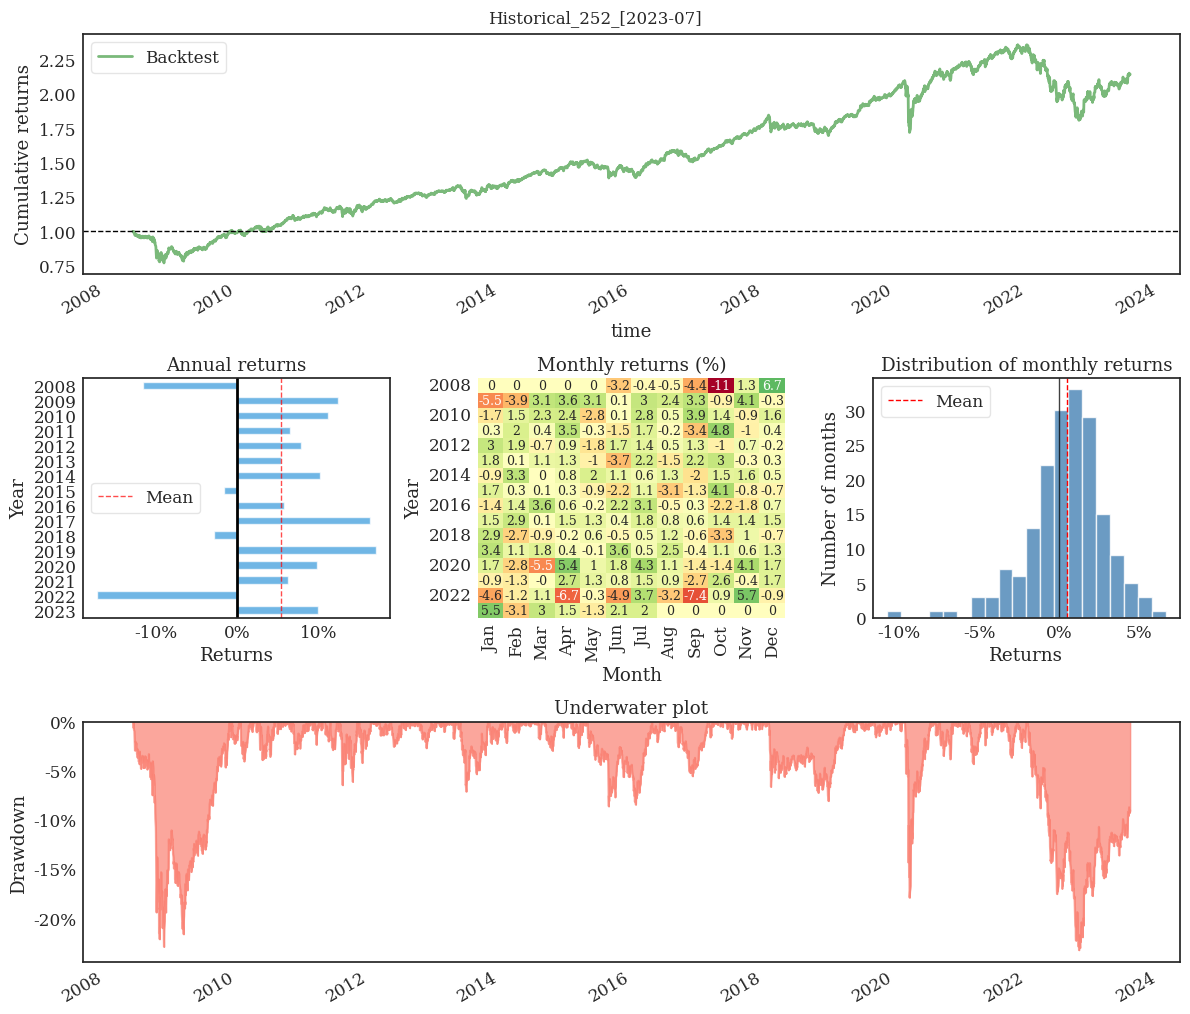

<IPython.core.display.Javascript object>

In [26]:
for col in strats.columns:
    plot_pf(strats[col])
    plt.suptitle(col.title(), y=1.01)
    plt.savefig("../visuals/performance_plots/"+col)

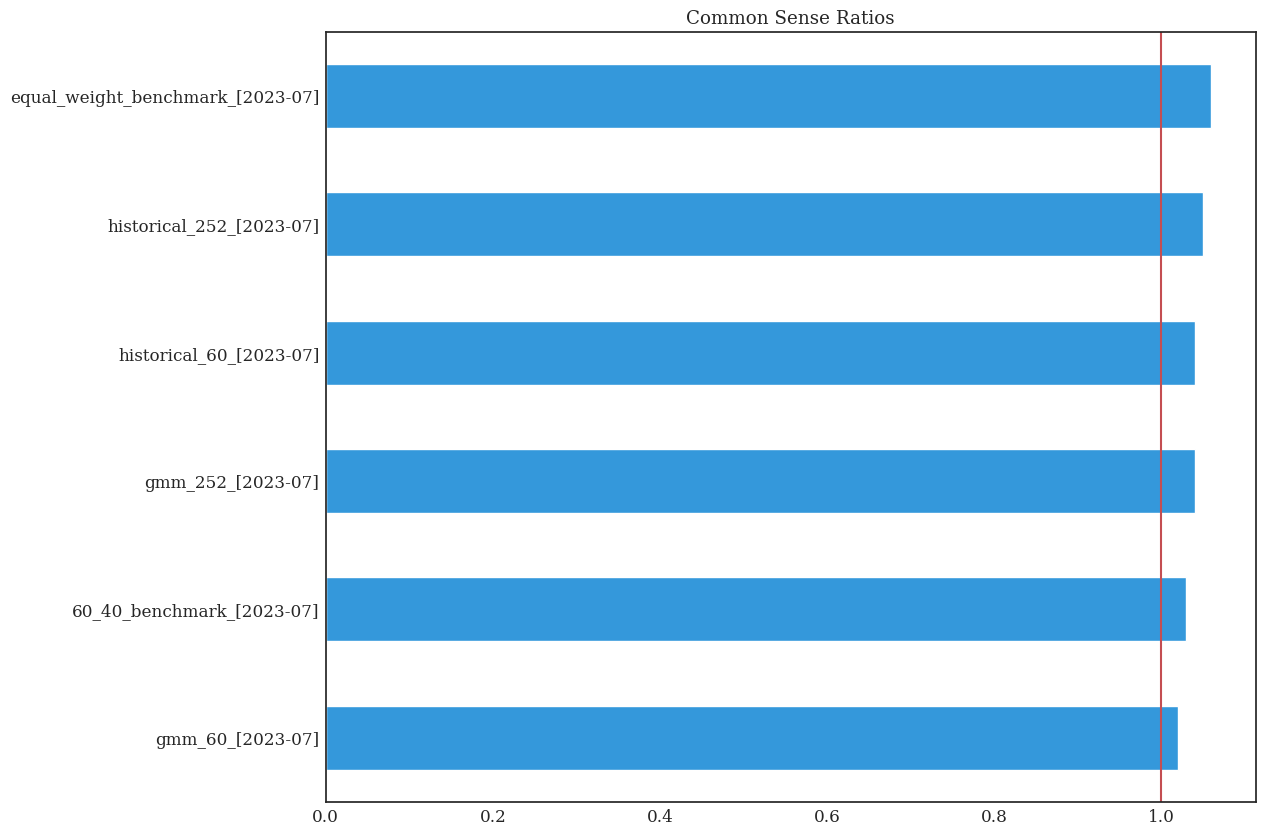

<IPython.core.display.Javascript object>

In [27]:
ax = (
    strat_res.loc["common_sense_ratio"]
    .sort_values()
    .plot.barh(title="Common Sense Ratios")
)

plt.axvline(1.0, color="r")

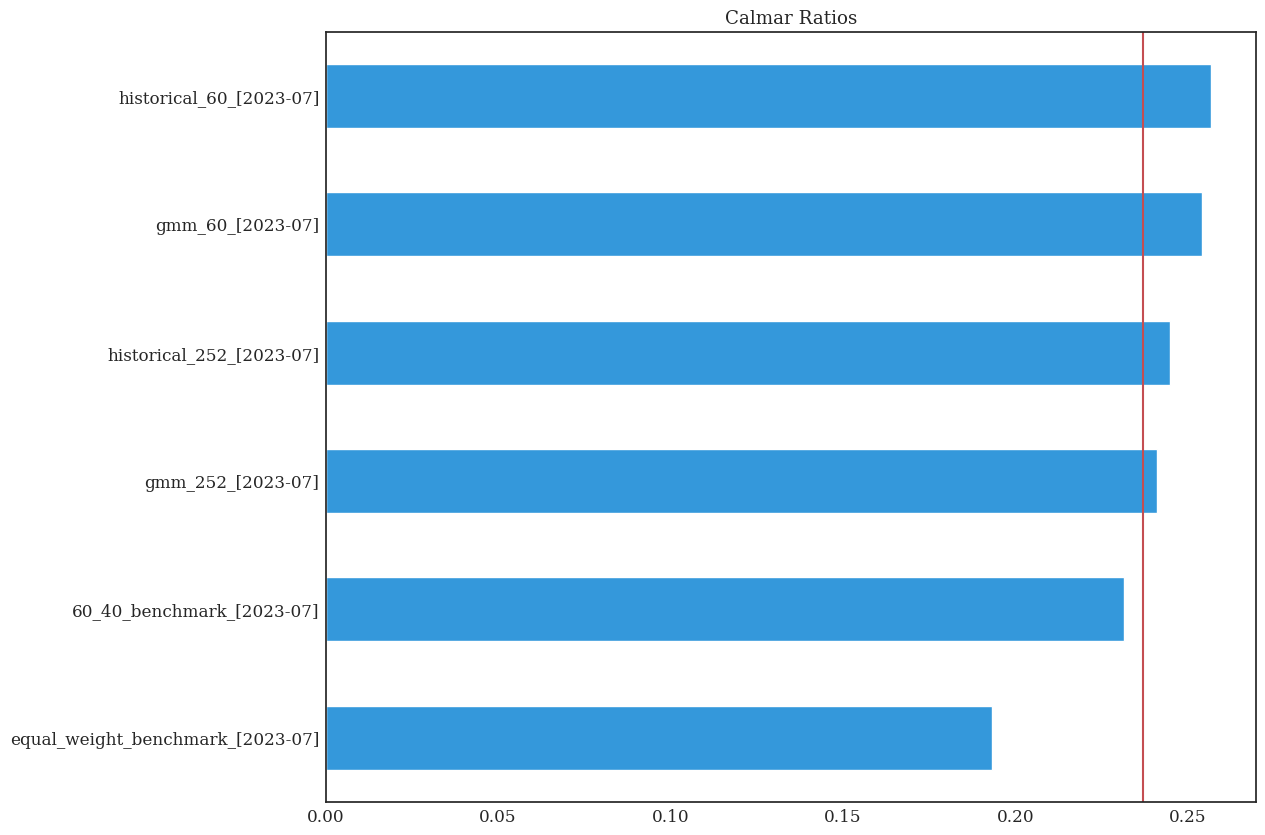

<IPython.core.display.Javascript object>

In [28]:
ax = strat_res.loc["calmar"].sort_values().plot.barh(title="Calmar Ratios")
plt.xlim(0)
plt.axvline(strat_res.loc["calmar"].mean(), color="r")
#add_watermark(ax, scale=1.25)

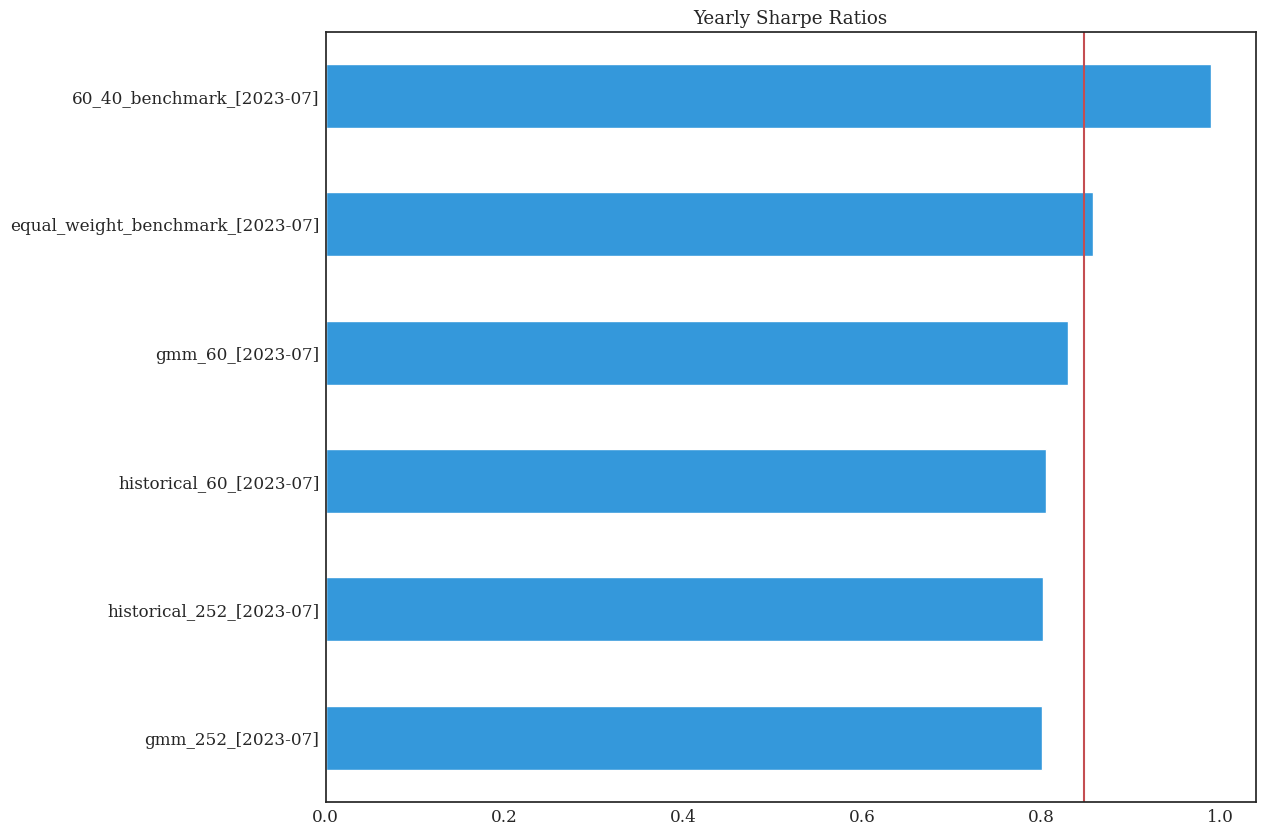

<IPython.core.display.Javascript object>

In [29]:
ax = (
    strat_res.loc["yearly_sharpe"].sort_values().plot.barh(title="Yearly Sharpe Ratios")
)
plt.axvline(strat_res.loc["yearly_sharpe"].mean(), color="r")
#add_watermark(ax, scale=1.25)

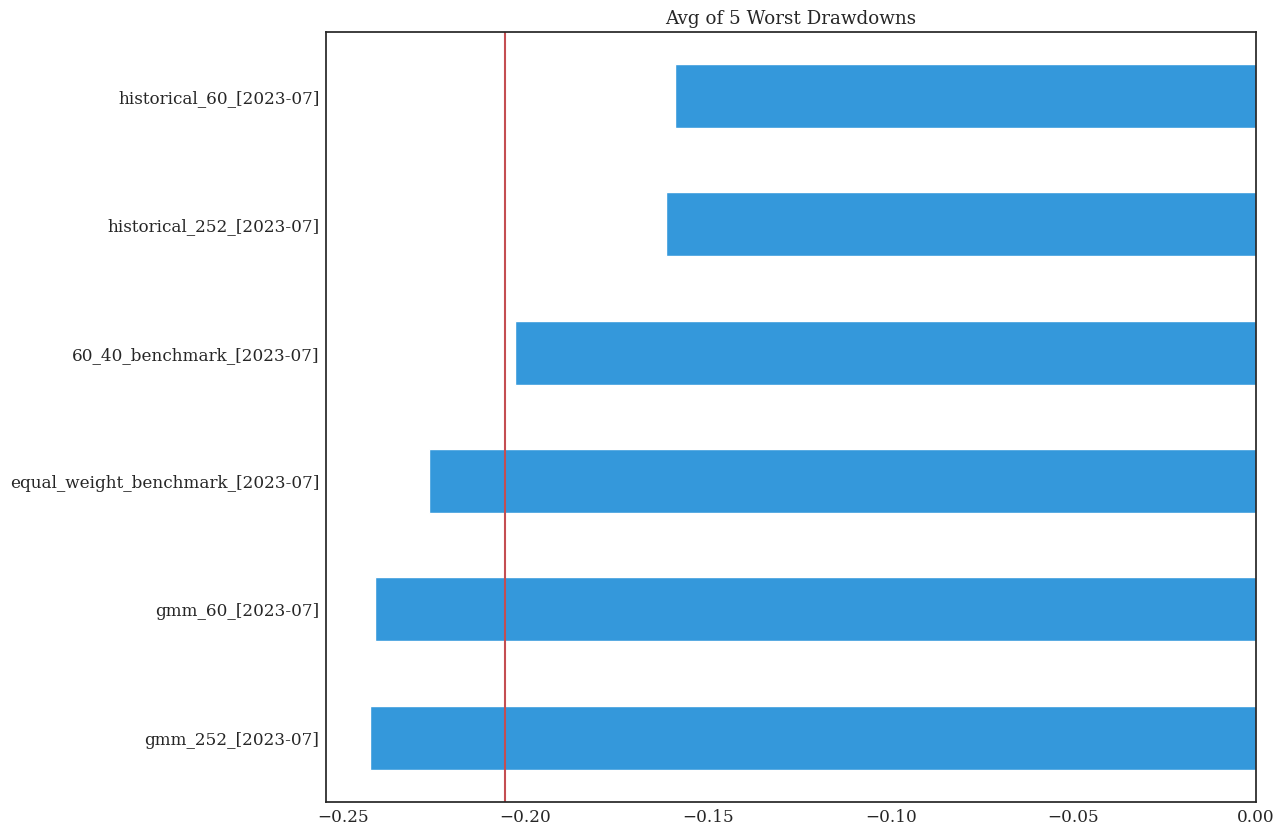

<IPython.core.display.Javascript object>

In [30]:
ax = (
    strat_res.loc["avg_worst_5_drawdowns"]
    .sort_values(ascending=True)
    .plot.barh(title="Avg of 5 Worst Drawdowns")
)
ax.axvline(strat_res.loc["avg_worst_5_drawdowns"].mean(), color="r")
#add_watermark(ax, scale=1.25)

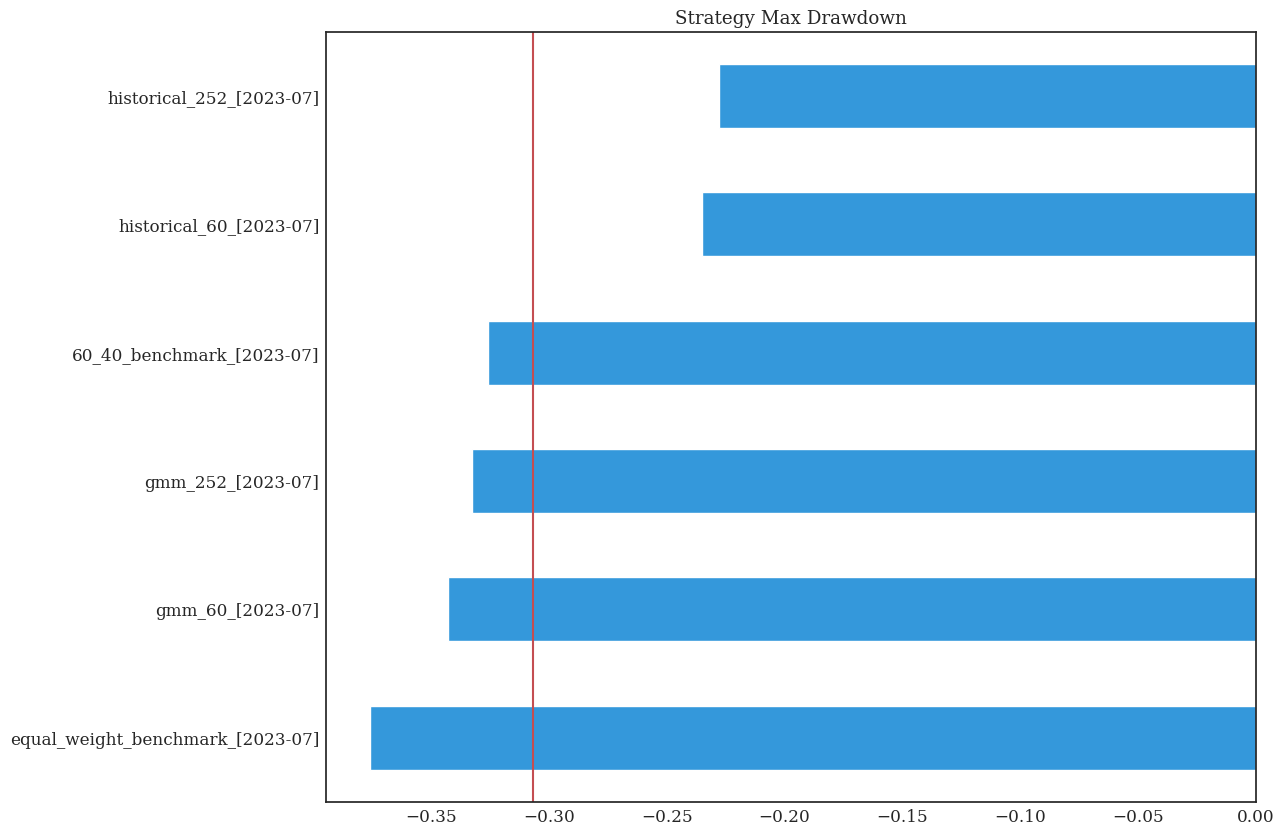

<IPython.core.display.Javascript object>

In [31]:
ax = (
    strat_res.loc["max_drawdown"].sort_values().plot.barh(title="Strategy Max Drawdown")
)
ax.axvline(strat_res.loc["max_drawdown"].mean(), color="r")

In [32]:
def plot_avg_drawdown_grid():
    y = "avg_worst_5_drawdowns"
    x = "avg_worst_5_drawdown_duration"

    g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
    label_point(
        strat_res.T[x],
        strat_res.T[y],
        pd.Series(strat_res.T.index, index=strat_res.T.index),
        plt.gca(),
        va="bottom",
        ha="center",
    )
    plt.suptitle(
        "Avg of 5 Worst Drawdowns vs Drawdown Durations",
        fontsize=14,
        fontweight="demi",
        y=1.05,
    )

    plt.gca().axhline(strat_res.loc["avg_worst_5_drawdowns"].mean(), ls="--")
    plt.gca().axvline(strat_res.loc["avg_worst_5_drawdown_duration"].mean(), ls="--")

<IPython.core.display.Javascript object>

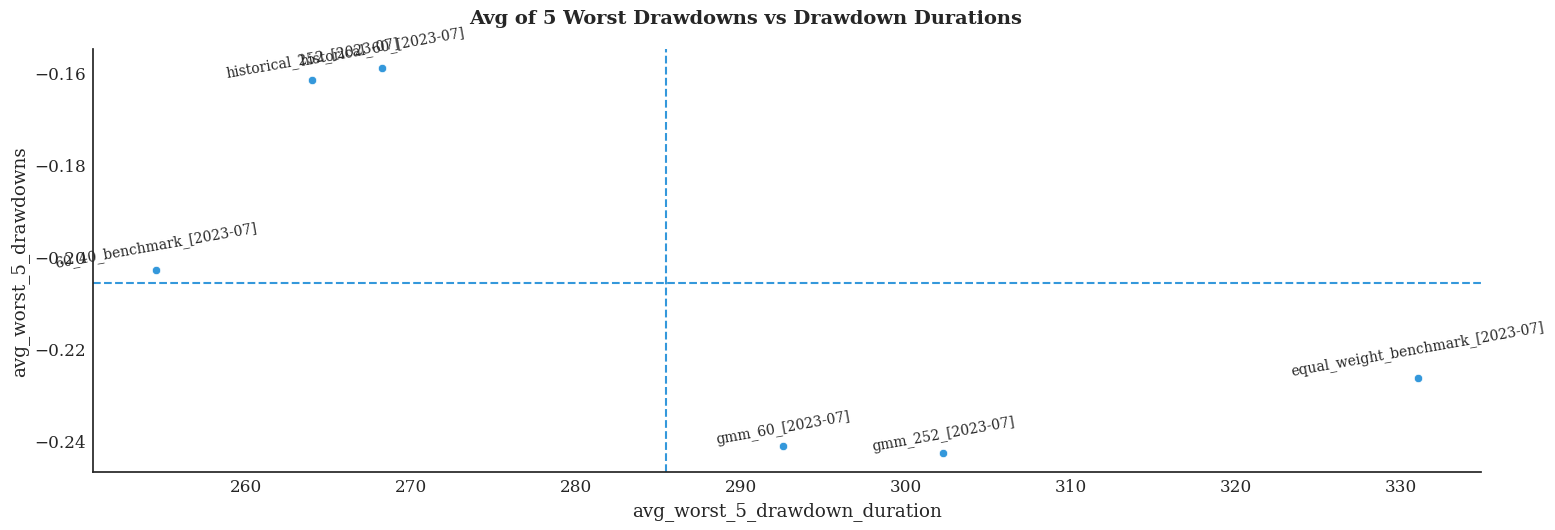

<IPython.core.display.Javascript object>

In [33]:
plot_avg_drawdown_grid()

In [34]:
def plot_csr_by_maxdd():
    x = "common_sense_ratio"
    y = "max_drawdown"

    g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
    label_point(
        strat_res.T[x],
        strat_res.T[y],
        pd.Series(strat_res.T.index, index=strat_res.T.index),
        plt.gca(),
        va="bottom",
        ha="center",
    )
    plt.title("Max Drawdown vs Common Sense Ratio", fontsize=14, fontweight="demi")
#    add_watermark(g.fig.axes, scale=2.0)
    plt.gca().axhline(strat_res.T[y].mean(), ls="--")
    plt.gca().axvline(strat_res.T[x].mean(), ls="--")
    return plt.gcf()

<IPython.core.display.Javascript object>

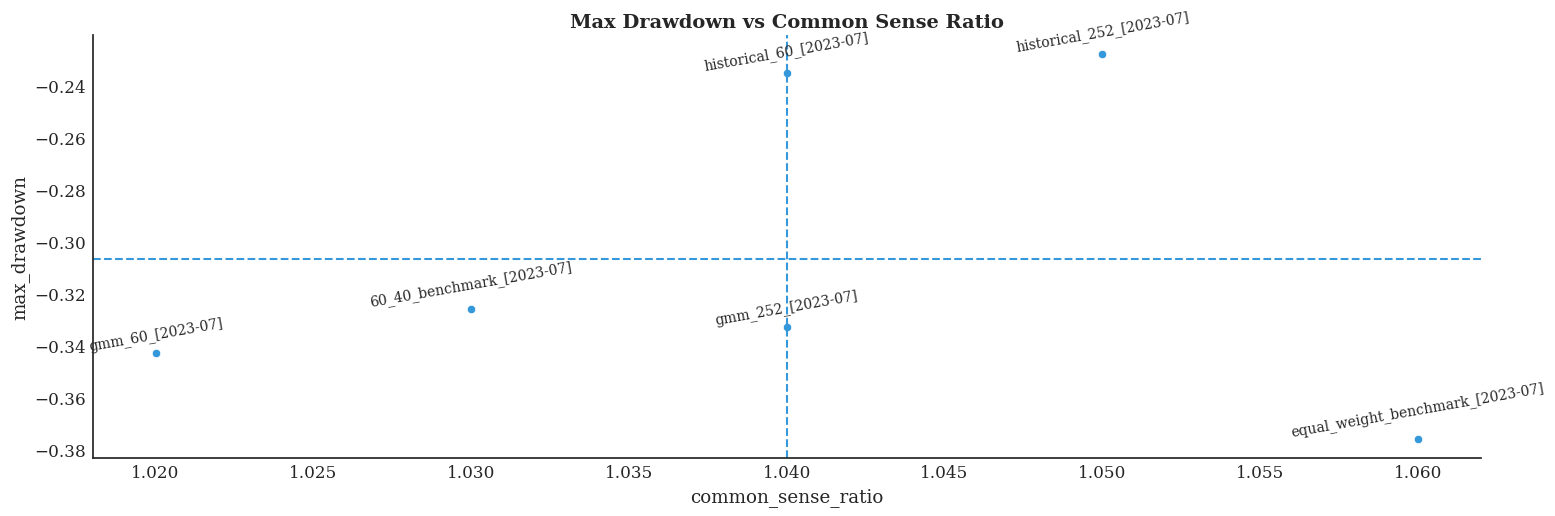

<IPython.core.display.Javascript object>

In [35]:
_ = plot_csr_by_maxdd()

In [36]:
def plot_maxdd_by_sharpe():
    x = "max_drawdown"
    y = "yearly_sharpe"

    g = sns.relplot(x=x, y=y, data=strat_res.T, aspect=3)
    label_point(
        strat_res.T[x],
        strat_res.T[y],
        pd.Series(strat_res.T.index, index=strat_res.T.index),
        plt.gca(),
    )
    plt.title("Max Drawdown vs Yearly Sharpe", fontsize=14, fontweight="demi")
#    add_watermark(g.fig.axes, scale=2.0)
    plt.gca().axhline(strat_res.T[y].mean(), ls="--")
    plt.gca().axvline(strat_res.T[x].mean(), ls="--")
    return plt.gcf()

<IPython.core.display.Javascript object>

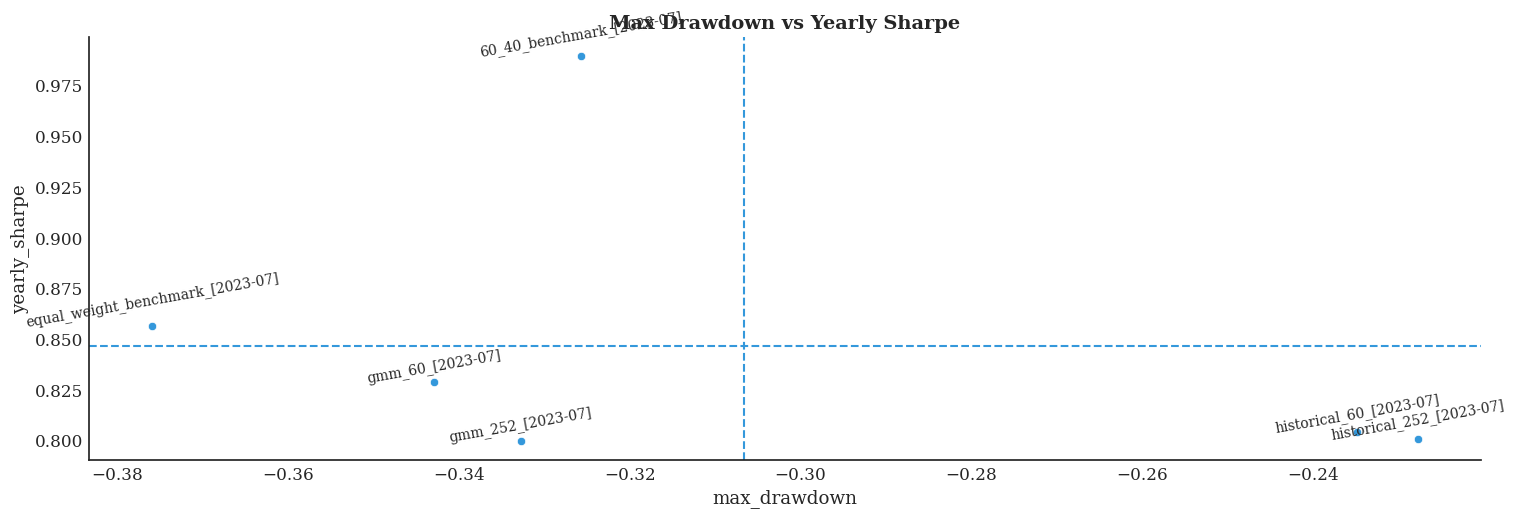

<IPython.core.display.Javascript object>

In [37]:
_ = plot_maxdd_by_sharpe()

In [38]:
perf["gmm_252_[2023-07]"].display_monthly_returns()

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug     Sep     Oct    Nov    Dec     YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  ------  ------  -----  -----  ------
  2008   0      0      0      0      0     -4.96  -0.51  -0.71   -6.73  -15.47   1.82  10.52  -16.7
  2009  -8.33  -5.61   4.69   5.46   4.4    0.16   4.33   3.65    5.04   -1.26   6.06  -0.33   18.43
  2010  -2.86   2.41   3.77   3.62  -4.45  -0.09   4.41   0.32    6.52    2.16  -1.23   2.08   17.37
  2011   0.32   3.04   0.51   5.35  -0.59  -2.21   2.45  -0.16   -5.33    7.83  -1.52   0.42    9.87
  2012   5.05   3.34  -0.9    1.27  -3.44   2.92   2.19   0.9     1.95   -1.56   1.06  -0.29   12.9
  2013   3.09   0.23   1.66   1.96  -1.39  -5.54   3.53  -2.33    3.46    4.67  -0.51   0.55    9.28
  2014  -1.41   5.18  -0.05   1.04   3      1.76   0.87   2.03   -3.23    2.25   2.41   0.84   15.43
  2015   2.48   0.62   0.02   0.59  -1.41  -3.3    1.78  -4.82   -1.84    6.5   -1.1   -1.03 

<IPython.core.display.Javascript object>

<Figure size 1200x1000 with 0 Axes>

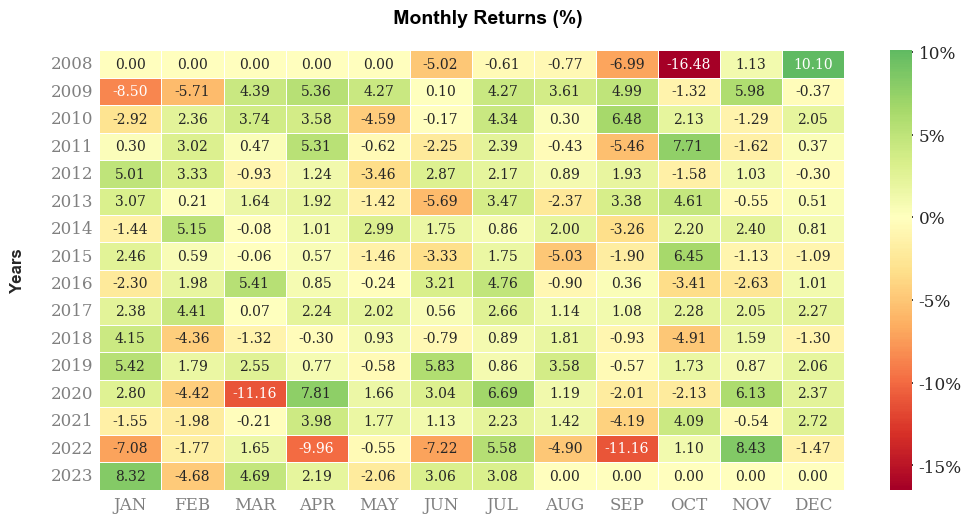

<IPython.core.display.Javascript object>

In [39]:
plt.figure(figsize=(12, 10))
qs.plots.monthly_heatmap(strats["gmm_252_[2023-07]"])


## Conclusions

The `gmm2_60` algorithm is the updated winner on a risk-adjusted basis. It had the highest common sense ratio relative to max drawdown. It was also in the upper left quadrant of the 'Average 5 Worst' chart demonstrating a relatively low average 5 worst drawdown to average 5 worst drawdown duration. 

However as can be seen below the gmm had the highest cagrs followed by the benchmarks.

In [40]:
strat_res.T.cagr.sort_values(ascending=False)

gmm_60_[2023-07]                   0.0872
gmm_252_[2023-07]                  0.0803
60_40_benchmark_[2023-07]          0.0754
equal_weight_benchmark_[2023-07]   0.0726
historical_60_[2023-07]            0.0603
historical_252_[2023-07]           0.0558
Name: cagr, dtype: object

<IPython.core.display.Javascript object>

In [41]:
strat_res.T.sort_values("common_sense_ratio", ascending=False)

,start,end,rf,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,daily_mean,...,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc,common_sense_ratio,avg_worst_5_drawdown_duration,avg_worst_5_drawdowns
equal_weight_benchmark_[2023-07],2008-06-01 04:00:00+00:00,2023-07-25 20:00:00+00:00,0.0000,1.8904,0.0726,-0.3759,0.1931,0.5352,0.8345,0.0671,...,-0.1809,-0.0144,21.9688,0.0258,-0.0272,0.8000,0.8538,1.0600,331.0000,-0.2264
historical_252_[2023-07],2008-06-01 04:00:00+00:00,2023-07-25 20:00:00+00:00,0.0000,1.2747,0.0558,-0.2278,0.2448,0.6174,0.9627,0.0490,...,-0.1648,-0.0107,22.2136,0.0185,-0.0189,0.8000,0.8538,1.0500,264.0000,-0.1616
gmm_252_[2023-07],2008-06-01 04:00:00+00:00,2023-07-25 20:00:00+00:00,0.0000,2.2195,0.0803,-0.3328,0.2412,0.5969,0.9290,0.0727,...,-0.2426,-0.0161,22.3227,0.0286,-0.0285,0.8000,0.8596,1.0400,302.2500,-0.2426
historical_60_[2023-07],2008-06-01 04:00:00+00:00,2023-07-25 20:00:00+00:00,0.0000,1.4286,0.0603,-0.2349,0.2569,0.6700,1.0629,0.0526,...,-0.1698,-0.0106,21.1818,0.0184,-0.0189,0.8000,0.8363,1.0400,268.2500,-0.1591
60_40_benchmark_[2023-07],2008-06-01 04:00:00+00:00,2023-07-25 20:00:00+00:00,0.0000,2.0072,0.0754,-0.3257,0.2315,0.6299,0.9601,0.0671,...,-0.1598,-0.0106,17.2391,0.0213,-0.0273,0.8667,0.8772,1.0300,254.5000,-0.2028
gmm_60_[2023-07],2008-06-01 04:00:00+00:00,2023-07-25 20:00:00+00:00,0.0000,2.5464,0.0872,-0.3429,0.2542,0.6473,1.0190,0.0779,...,-0.2471,-0.0160,21.9196,0.0284,-0.0291,0.8000,0.8363,1.0200,292.5000,-0.2411


<IPython.core.display.Javascript object>

In [42]:
strat_res.to_csv('../results/strategy_results.csv')

<IPython.core.display.Javascript object>